##Import data

In [15]:
# from google.colab import drive
# drive.mount('/drive')

# #driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/USPollenDataset/"
# driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PollenVsNotPollen/"


# #labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/classes.txt"
# labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/binaryClasses.txt"


# weightsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PvNP_Weights/Xception192x192/"
# weightsFile = weightsDir+"Xception192x192.h5"

# dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
# imgDir = dDir+"MicroscopeImagesandVideos/test.jpg"


In [43]:
from google.colab import drive
drive.mount('/drive')

driveDir = "/drive/My Drive/PollenImageClassification/"
labelsDir = driveDir + "binaryClasses.txt"

weightsDir = driveDir + "PvNP_Weights/"
weightsFile = weightsDir + "Xception192x192.h5"

dDir = driveDir
imgDir = dDir+"MicroscopeImagesandVideos/test.jpg"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [45]:
def loadDataset(classLabels,imagesDir):
    data = []
    labels = []
    glober = []
    classDict = []
    with open(classLabels,"r") as f:
        for line in f.readlines():
            key = line.strip()
            glober = glob.glob(imagesDir+key+"/*.jpg")
            myClass = np.array(glober)
            classDict.append(key)
            for i in myClass:
                #make sure to map images to brg color values
                #broadcast error because some images will read in (b,g,r,255)
                img = cv2.imread(i, cv2.IMREAD_COLOR) 
                data.append(img)
                labels.append(key)

    return [data,labels]
        

    

##Image Preprocessing

In [46]:
def resizeDataset(X, width=341, height=512):
    X_new = []
    for a in range(X.shape[0]):
        result = cv2.resize(X[a], (width,height))
        X_new.append(result)
    return np.array(X_new)

##Model


In [47]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.applications import VGG16

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [48]:
#Transfer Learned 
class PollenTypeCNN(Model):
    def __init__(self,**kwargs):
        super(PollenTypeCNN,self).__init__(**kwargs)
        self.X = None #Images
        self.labels = None #Labels
        self.OneHotLabels = None #Integer Mapped Labels
        self.data_train = None
        self.data_test = None
        self.history = None
        self.newMod = None
        
    def buildModel(self, input_shape=(1364, 2048, 3)):
        self.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.MaxPooling2D((2, 2)))
        self.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.add(layers.Flatten())
        self.add(layers.Dense(64, activation='relu'))
        self.add(layers.Dense(2,activation='softmax'))
        self.summary()
        self.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    def buildTransferLearnedModel(self,classes = 42,input_shape=(1364, 2048, 3)):
        model = tf.keras.applications.Xception(weights = "imagenet", include_top=False, input_shape = input_shape)

        for layer in model.layers[:-8]:
            layer.trainable = False
        
        x = model.output
        x = GlobalAveragePooling2D()(x)
        x = Flatten()(x)
        x = Dense(4096, activation="relu")(x)
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.4)(x)
        predictions = Dense(classes, activation="softmax")(x)

        #Functional not Sequential for transfer learned CNN
        self.newMod = Model(model.input,predictions)
        self.newMod.summary()
        self.newMod.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
        
    def loadData(self, trainDirs=["",""]):
        data = loadDataset(classLabels=trainDirs[0], imagesDir=trainDirs[1])
        self.X = np.array(data[0])
        self.labels = np.array(data[1])
        
    def preprocess(self, resizeWidth = 341, resizeHeight = 512, testRatio = 0.1):
        #
        self.X = resizeDataset(self.X, width=resizeWidth, height=resizeHeight)
        self.X = np.array(self.X, dtype="float") / 255.0

        le = LabelEncoder()

        self.OneHotLabels = le.fit_transform(self.labels)
        y = to_categorical(self.OneHotLabels)
        #Train test split
        (trainX, testX, trainY, testY) = train_test_split(self.X, y,test_size=testRatio, random_state=42)
        self.data_train = [trainX,trainY]
        self.data_test = [testX,testY]

    def trainModel(self, epochs=10, batch_size=32,augment_batch_size = 8):
        #Data Augmentation
        aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

        train_generator = aug.flow(self.data_train[0],self.data_train[1],batch_size = augment_batch_size)
        test_generator = aug.flow(self.data_test[0],self.data_test[1],batch_size = augment_batch_size)

        self.history = model.fit(train_generator, epochs=epochs, batch_size=batch_size,
                    validation_data= test_generator)
        
    def kMeansTrainModel(self, classes = 42,epochs=10, batch_size=32,augment_batch_size = 8,kfolds = 10,weightsName = "VGG16"):
        kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=7)


        #Callbacks
        checkpoint = ModelCheckpoint(weightsName+".h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto',save_freq='epoch')
        early = EarlyStopping(monitor='val_accuracy', patience=50, verbose=1, mode='auto')

        callbacks = [checkpoint,early]

        for train, test in kfold.split(self.X,self.OneHotLabels):
            #Data Augmentation
            aug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest")

            #y vec needs to be 1d vector of all labels initally
            #change to categorical values after the split
            #https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
            cat_trainY = to_categorical(self.OneHotLabels[train], classes)
            cat_testY = to_categorical(self.OneHotLabels[test], classes)

            train_generator = aug.flow(self.X[train],cat_trainY,batch_size = augment_batch_size)
            test_generator = aug.flow(self.X[test],cat_testY,batch_size = 1)

            self.history = self.newMod.fit(train_generator, epochs=epochs, batch_size=batch_size,
                    validation_data= test_generator,callbacks = callbacks)
        
    def graphAccuracy(self):
        history = self.history
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')

    def make_prediction(self,image,class_dictionary):
        #Rescale image
        img = image/255.

        #Convert to a 4D tensor
        image = np.expand_dims(img, axis=0)
        #print(image.shape)

        # make predictions on the preloaded model
        class_predicted = self.newMod.predict(image)
        inID = np.argmax(class_predicted)
        label = class_dictionary[inID]
        return label


##Main

In [49]:
dirs = [labelsDir, driveDir]


model = PollenTypeCNN()

#model.buildModel(input_shape=(40, 40, 3))

model.buildTransferLearnedModel(classes = 2,input_shape=(192, 192, 3))

model.loadData(trainDirs=dirs)

model.preprocess(resizeWidth = 192, resizeHeight = 192,testRatio=0.1)

#model.trainModel(epochs=500, batch_size=32,augment_batch_size = 8)

#parameters determined from old classifier
model.kMeansTrainModel(classes = 2,epochs = 64,batch_size = 16,augment_batch_size = 12,kfolds = 10,weightsName=weightsDir )

model.graphAccuracy()



#model.save_weights(weightsDir+"VGG16-Type.h5")

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

ValueError: ignored

##Load Model

In [50]:
model = PollenTypeCNN()

model.buildTransferLearnedModel(classes = 2,input_shape=(192, 192, 3))

model.newMod.load_weights(weightsFile)



Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

##Microscope slide test

In [51]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist 

In [52]:
class PollenPreprocessing():
    def __init__(self):
        self.image = None
        self.mask = None
        self.centers = None
    

    def readImg(self,dir):
        startImg = cv2.imread(dir)
        self.image = np.array(startImg)
        return self.image

    def showImg(self,image):
        imgCopy = image
        plt.imshow(imgCopy)
        plt.show()

    def resizeImg(self,image,ratio=4):
        l = image.shape[0]
        w = image.shape[1]
        return cv2.resize(image,(l*ratio,l*ratio))

    def getRects(self,image,size = (64,64)):
        newImg = copy.copy(image)
        length = newImg.shape[0]
        width = newImg.shape[1]
        rects = []
        x1 = 0
        y1 = 0
        #Top down 
        while y1 + size[1] < length:
            while x1 + size[0] < width:
                x2 = x1+size[0]
                y2 = y1+size[1]
                rects.append(newImg[y1:y2,x1:x2].copy())
                x1 = x2
            y1 = y2
            x1 = 0

        return np.array(rects)

    #Run for optimal k value
    def kMeansElbowTest(self,maxK,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            #the below line of code defines the criteria for the algorithm to stop running,  
            #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
            #becomes 85% 
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            distortions = [] 

            K = range(1,maxK)
              
            for k in K: 
                # then perform k-means clustering wit h number of clusters defined as 3 
                #also random centres are initally chosed for k-means clustering 
                retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)     
                distortions.append(sum(np.min(cdist(vectorized, self.centers,'euclidean'),axis=1)) / vectorized.shape[0]) 
                

            plt.plot(K, distortions, 'bx-') 
            plt.xlabel('Values of K') 
            plt.ylabel('Distortion') 
            plt.title('The Elbow Method using Distortion') 
            plt.show() 
        else:
            print("No Image Loaded")

    def kMeans(self,k,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            # then perform k-means clustering wit h number of clusters defined as 3 
            #also random centres are initally chosed for k-means clustering 
            retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # convert data into 8-bit values 
            self.centers = np.uint8(self.centers) 
            segmented_data = self.centers[labels.flatten()] 
              
            # reshape data into the original image dimensions 
            self.mask = segmented_data.reshape((self.image.shape)) 

            #Plot result during testing phase
            plt.imshow(self.mask)
            plt.title('Final'), plt.xticks([]), plt.yticks([])
            plt.show()
        else:
             print("No Image Loaded")

        
    def threshold(self,low,high,HSV = True):
        if self.image.any() != None:
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
        
            # Define lower and uppper limits of what we call "brown"
            brown_lo=np.array(low)
            brown_hi=np.array(high)

            # Mask image to only select browns
            mask=cv2.inRange(self.image,brown_lo,brown_hi)
            self.image[mask>0] = self.centers[-1] #last in center array is largest group in kmeans ... background color

            #Convert back to BGR 
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_HSV2BGR)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_RGB2BGR)

            plt.imshow(self.image)
            plt.show()
        else:
            print("No Image Loaded")
        





    

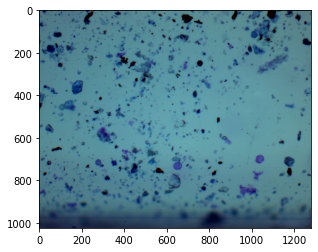

In [53]:


poll = PollenPreprocessing()
img = poll.readImg(imgDir)
poll.showImg(img)
resized = poll.resizeImg(img,4)
rects = poll.getRects(resized,size=(192,192))

In [54]:
imgs = []
guesses = []
pollenInd = []
class_dictionary = ["Not Pollen","Pollen"]
for val,i in enumerate(rects):
    b,g,r = cv2.split(i)           # get b, g, r
    img = cv2.merge([r,g,b])
    imgs.append(img)
    #plt.imshow(img)
    #plt.show()
    guesses.append(model.make_prediction(i,class_dictionary))
    #print(guesses[val]+repr(val))
    if guesses[val] == class_dictionary[1]:
        pollenInd.append(val)


In [55]:
pollen = guesses.count(class_dictionary[1])
nonpollen = guesses.count(class_dictionary[0])

print((pollen/rects.shape[0])*100)
print((nonpollen/rects.shape[0])*100)

1.3605442176870748
98.63945578231292


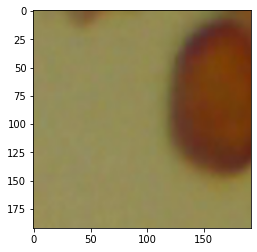

Pollen


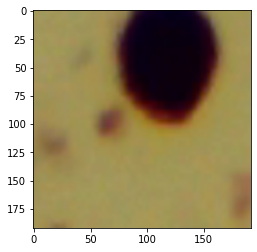

Pollen


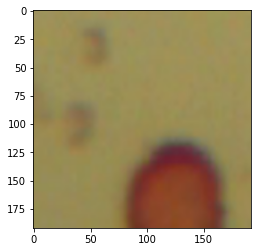

Pollen


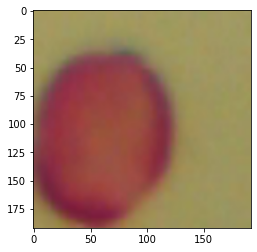

Pollen


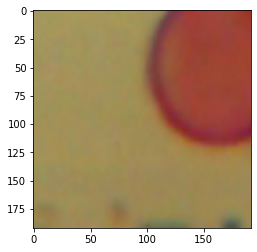

Pollen


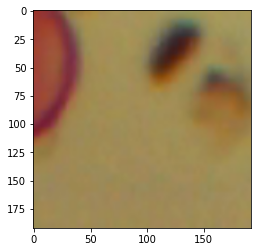

Pollen


In [56]:
for val,i in enumerate(pollenInd):
    b,g,r = cv2.split(rects[i])           # get b, g, r
    img = cv2.merge([r,g,b])
    plt.imshow(img)
    plt.show()
    print(guesses[i])

##Not used

In [ ]:
class TransferLearnedCNN(Model):
    def __init__(self,**kwargs):
        super(TransferLearnedCNN,self).__init__(**kwargs)
        self.model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224,3))
        self.out = self.model.layers[-1]
        self.flat1 = Flatten()
        self.dense1 = Dense(256, activation="relu")
        self.drop = Dropout(0.4)
        self.dense2 = Dense(4096, activation="relu")
        self.predictions = Dense(42, activation="softmax")

        # creating the final model 
        #self.final_model = Model(model.input,predictions)
    
    def call(self,inputs = (224,224,3)):
        x = self.model(inputs)
        x = self.out(x)
        x = self.flat1()(x)
        x = self.dense1()(x)
        x = self.drop()(x)
        x = self.dense2()(x)
        output = self.predictions()(x)

    def model(self):
        x = keras.Input(shape = (224,224,1))
        return keras.Model(inputs[x],outputs = self.call(x))